# Libraries

In [2]:
import pandas as pd
import re
import string
import time
import numpy as np

# %pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

from kerastuner import RandomSearch, HyperModel

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

# REPLACED - Original preprocessing functions

## Data cleaning: strip, lower, digit, punctuation

In [3]:
# def basic_cleaning(text):
#     # stripping:
#     data['text'] = data['text'].str.strip()

#     # tolower:
#     data['text'] = data['text'].str.lower()

#     # digit: Remove digits from each row of the ‘text’ column
#     data['text'] = data['text'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

#     # punctuation: Remove all punctuation marks from the ‘text’ column
#     data['text'] = data['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)

#     # delete html-tags
#     data['text'] = data['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

#     return data['text']


## Data cleaning: tokenizing, stopwords, lemmatize

In [4]:
# stop_words = set(stopwords.words('english'))

# # Tokenise and remove stop words
# def delete_stop_words(text):
#     return [word for word in text if word.lower() not in stop_words and word not in string.punctuation]

# # apply Lemmatization-Funktion
# def lemmatize_text(text):
#     lemmatizer = WordNetLemmatizer()
#     # Verben lemmatisieren
#     verb_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in text]
#     # Nomen lemmatisieren
#     return [lemmatizer.lemmatize(word, pos="n") for word in verb_lemmatized]

# NLP-Cleaningfunktion
# def nlp_cleaning(texte):
#     # Tokenisation
#     texte = texte.apply(word_tokenize)
#     # Remove stop words
#     texte = texte.apply(delete_stop_words)
#     # Lemmatisation
#     texte = texte.apply(lemmatize_text)
#     # Combine words into a string
#     return texte.apply(lambda x: ' '.join(x))


# Load and Preprocess Data

### Load data

In [5]:
# Load the data
data = pd.read_csv('../data/raw_data.csv')

In [6]:
data.shape

(72134, 4)

In [7]:
data['text'] = data['text'].astype('string')
data['title'] = data['title'].astype('string')
data['label'] = data['label'].astype('bool')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  string
 2   text        72095 non-null  string
 3   label       72134 non-null  bool  
dtypes: bool(1), int64(1), string(2)
memory usage: 1.7 MB


In [9]:
data.label.value_counts()


True     37106
False    35028
Name: label, dtype: int64

### Replace N/As

In [10]:
# Fill missing values with spaces
data = data.fillna(' ')

# Verify that there are no missing values
print(data.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


### Concatenate features

In [11]:
# Combine 'title' and 'text' columns, then drop 'title' column
data['text'] = data['title'] + ' ' + data['text']
data.drop('title', axis=1, inplace=True)

# Set the index to maintain the original indexing
data.set_index('Unnamed: 0', inplace=True)

# Verify the changes
print(data.head(2))

                                                         text  label
Unnamed: 0                                                          
0           LAW ENFORCEMENT ON HIGH ALERT Following Threat...   True
1              Did they post their votes for Hillary already?   True


### Train-Test Split

In [12]:
# Separate the features (text) and labels (label) into X and y
X = data['text']
y = data['label']

# Verify the separation
print(X.shape)
print(y.shape)

(72134,)
(72134,)


In [13]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify the shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (50493,), X_test shape: (21641,)
y_train shape: (50493,), y_test shape: (21641,)


### Basic cleaning

In [14]:
def basic_cleaning(text: str) -> str:
    text = text.strip().lower()
    text = ''.join(char for char in text if not char.isdigit())
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
    text = re.sub('<[^<]+?>', '', text)
    return text

In [15]:
# Apply basic cleaning to the 'text' column
X_train_clean = X_train.apply(basic_cleaning)
X_test_clean = X_test.apply(basic_cleaning)
# Verify the changes
print(X_train_clean.head(2))
print(X_test_clean.head(2))

Unnamed: 0
60480    media goes nuts after trump tweets hilarious v...
61738    poll finds white republicans are angry nearly ...
Name: text, dtype: object
Unnamed: 0
61370    arnold schwarzenegger sends a message to liber...
2189     wow “we mexicans need to kill donald trump bef...
Name: text, dtype: object


In [16]:
X_train_clean.shape, X_test_clean.shape

((50493,), (21641,))

### NLP cleaning

In [17]:
stop_words = set(stopwords.words('english'))

# Tokenise and remove stop words
def delete_stop_words(text):
    return [word for word in text if word.lower() not in stop_words and word not in string.punctuation]

# Apply Lemmatization Function
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Lemmatize verbs
    verb_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in text]
    # Lemmatize nouns
    return [lemmatizer.lemmatize(word, pos="n") for word in verb_lemmatized]

# Combined NLP Cleaning Function
def nlp_cleaning(text: str) -> str:
    tokens = word_tokenize(text)
    tokens = delete_stop_words(tokens)
    tokens = lemmatize_text(tokens)
    return ' '.join(tokens)


In [18]:
# Apply NLP cleaning to the 'text' column
X_train_processed = X_train_clean.apply(nlp_cleaning)
X_test_processed = X_test_clean.apply(nlp_cleaning)

# Verify the changes
print(X_train.head(2))
print(X_train_processed.head(2))

Unnamed: 0
60480    MEDIA GOES NUTS After Trump Tweets HILARIOUS V...
61738     Poll Finds White Republicans Are Angry Nearly...
Name: text, dtype: string
Unnamed: 0
60480    medium go nut trump tweet hilarious video show...
61738    poll find white republican angry nearly time n...
Name: text, dtype: object


In [19]:
X_train_processed.shape, X_test_processed.shape

((50493,), (21641,))

### Tokenize and Pad Sequences

In [20]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_processed)
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

# Pad the sequences to ensure they have the same length
max_length = 500
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, dtype='float32', padding='pre', value=0)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, dtype='float32', padding='pre', value=0)


In [21]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [22]:
X_train_padded.shape, X_test_padded.shape

((50493, 500), (21641, 500))

In [23]:
# Verify the tokenized and padded sequences
print(X_train_padded[:5])

[[   0.    0.    0. ...   37.  106.   10.]
 [   0.    0.    0. ...  175.  271. 4240.]
 [   0.    0.    0. ... 3297. 1262. 1763.]
 [   0.    0.    0. ... 4584.  227.  675.]
 [   0.    0.    0. ...  175.  309.  443.]]


In [24]:
# Verify the shapes
print(f"X_train shape: {X_train_padded.shape}, X_test shape: {X_test_padded.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (50493, 500), X_test shape: (21641, 500)
y_train shape: (50493,), y_test shape: (21641,)


# RNN models

## Tuning RNN Model 1 - Test accuracy = 0.59

In [98]:
# Instantiate the model
rnn_model_1 = Sequential()

# Add an embedding layer
rnn_model_1.add(Embedding(input_dim=5000, output_dim=128))

# Add a simple RNN layer with 128 units
rnn_model_1.add(SimpleRNN(units=128, return_sequences=False))

# Add dropout layers to prevent overfitting
rnn_model_1.add(Dropout(rate=0.5))

# Add another dense layer and dropout layer
rnn_model_1.add(Dense(units=64, activation='relu'))
rnn_model_1.add(Dropout(rate=0.5))

# Add the final dense output layer with sigmoid activation
rnn_model_1.add(Dense(units=1, activation='sigmoid'))


In [99]:
# Adjust the Adam optimizer parameters
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
rnn_model_1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Train the Model

In [100]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and model checkpoint
history_1 = rnn_model_1.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
789/789 [==============================] - 202s 254ms/step - loss: 0.6990 - accuracy: 0.5345 - val_loss: 0.6641 - val_accuracy: 0.5746
Epoch 2/10
789/789 [==============================] - 195s 248ms/step - loss: 0.6611 - accuracy: 0.5786 - val_loss: 0.6733 - val_accuracy: 0.5659
Epoch 3/10
789/789 [==============================] - 203s 258ms/step - loss: 0.6584 - accuracy: 0.5867 - val_loss: 0.6541 - val_accuracy: 0.5805
Epoch 4/10
789/789 [==============================] - 193s 245ms/step - loss: 0.6542 - accuracy: 0.6121 - val_loss: 0.6665 - val_accuracy: 0.6002
Epoch 5/10
789/789 [==============================] - 192s 243ms/step - loss: 0.6460 - accuracy: 0.5988 - val_loss: 0.6377 - val_accuracy: 0.6124
Epoch 6/10
789/789 [==============================] - 192s 243ms/step - loss: 0.6244 - accuracy: 0.6159 - val_loss: 0.6200 - val_accuracy: 0.6247
Epoch 7/10
789/789 [==============================] - 196s 248ms/step - loss: 0.6215 - accuracy: 0.6124 - val_loss: 0.6362 -

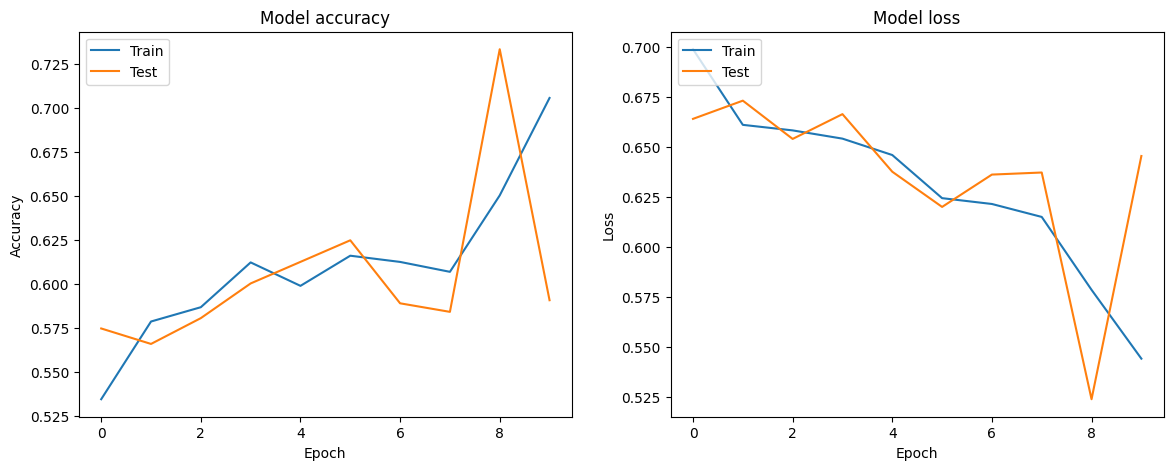

In [101]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Evaluate the Model

In [102]:
# Evaluate the model on the test data
loss_1, accuracy_1 = rnn_model_1.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy_1:.2f}")

677/677 [==============================] - 35s 52ms/step - loss: 0.6455 - accuracy: 0.5907
Test Accuracy: 0.59


Predict

In [103]:
# Generate predictions
y_pred_prob_1 = rnn_model_1.predict(X_test_padded)
# Convert probabs to 0 or 1
y_pred_1 = (y_pred_prob_1 > 0.5).astype(int)

677/677 [==============================] - 38s 55ms/step


In [104]:
# Performance metrics
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1)
recall_1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)

# Print performance metrics
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_1))


Accuracy: 0.59
Precision: 0.62
Recall: 0.49
F1 Score: 0.55
Classification Report:
               precision    recall  f1-score   support

       False       0.57      0.69      0.62     10613
        True       0.62      0.49      0.55     11028

    accuracy                           0.59     21641
   macro avg       0.60      0.59      0.59     21641
weighted avg       0.60      0.59      0.59     21641



In [105]:
# Calculate the confusion matrix
cm_1 = confusion_matrix(y_test, y_pred_1)

In [106]:
cm_1

array([[7329, 3284],
       [5574, 5454]])

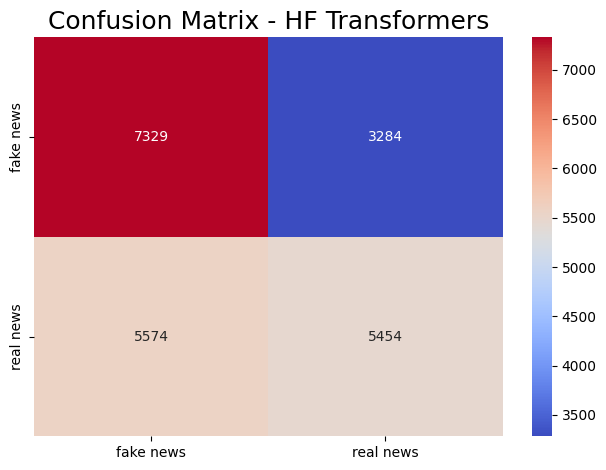

In [ ]:
ax = sns.heatmap(cm_1, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [108]:
rnn_model_1.save('trained_rnn_model_20241218_1125_ta_59.h5') # save in h5 compressed format

## Tuning RNN Model 2 - Test accuracy = 0.85

In [44]:
# Instantiate the model
rnn_model_2 = Sequential()

# Add an embedding layer
rnn_model_2.add(Embedding(input_dim=5000, output_dim=128))

# Add a simple RNN layer with 128 units
rnn_model_2.add(SimpleRNN(units=32, return_sequences=False))

# Add dropout layers to prevent overfitting
rnn_model_2.add(Dropout(rate=0.1))

# Add another dense layer and dropout layer
rnn_model_2.add(Dense(units=64, activation='relu'))
rnn_model_2.add(Dropout(rate=0.1))

# Add the final dense output layer with sigmoid activation
rnn_model_2.add(Dense(units=1, activation='sigmoid'))

In [47]:
# Adjust the Adam optimizer parameters
optimizer = RMSprop()

# Compile the model
rnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Train the Model

In [48]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and model checkpoint
history_2 = rnn_model_2.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
789/789 [==============================] - 156s 198ms/step - loss: 0.5616 - accuracy: 0.6863 - val_loss: 0.4533 - val_accuracy: 0.8469
Epoch 2/10
789/789 [==============================] - 156s 198ms/step - loss: 0.4362 - accuracy: 0.8177 - val_loss: 0.4062 - val_accuracy: 0.8514
Epoch 3/10
789/789 [==============================] - 154s 195ms/step - loss: 0.5142 - accuracy: 0.7155 - val_loss: 0.4120 - val_accuracy: 0.8506
Epoch 4/10
789/789 [==============================] - 155s 196ms/step - loss: 0.4664 - accuracy: 0.7640 - val_loss: 0.4970 - val_accuracy: 0.7469
Epoch 5/10
789/789 [==============================] - 155s 197ms/step - loss: 0.5605 - accuracy: 0.6504 - val_loss: 0.5812 - val_accuracy: 0.7160


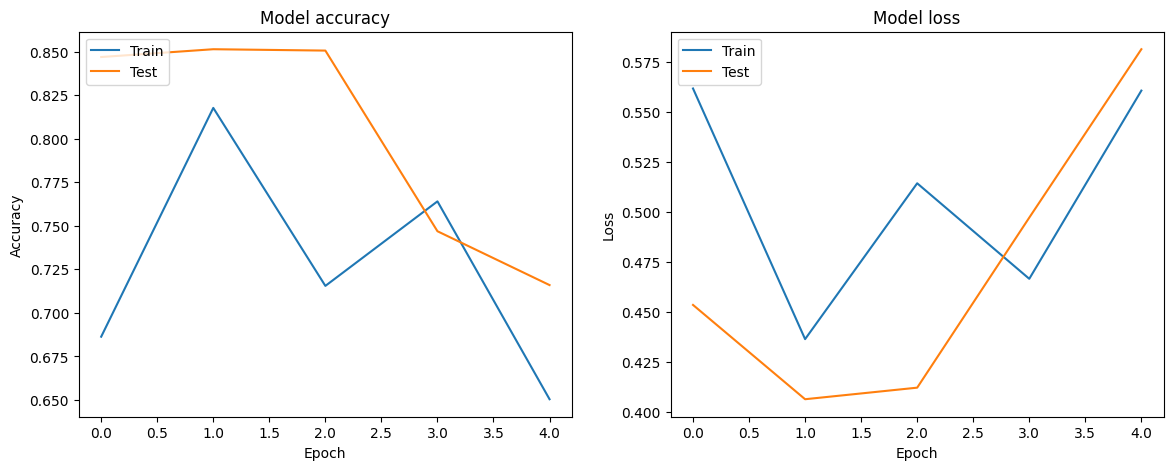

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Evaluate the Model

In [50]:
# Evaluate the model on the test data
loss_2, accuracy_2 = rnn_model_2.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy_2:.2f}")

677/677 [==============================] - 25s 37ms/step - loss: 0.4062 - accuracy: 0.8514
Test Accuracy: 0.85


Predict

In [51]:
# Generate predictions
y_pred_prob_2 = rnn_model_2.predict(X_test_padded)
# Convert probabs to 0 or 1
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)

677/677 [==============================] - 27s 39ms/step


In [52]:
# Performance metrics
perfomance_accuracy_2 = accuracy_score(y_test, y_pred_2)
perfomance_precision_2 = precision_score(y_test, y_pred_2)
perfomance_recall_2 = recall_score(y_test, y_pred_2)
perfomance_f1_2 = f1_score(y_test, y_pred_2)

# Print performance metrics
print(f"Accuracy: {perfomance_accuracy_2:.2f}")
print(f"Precision: {perfomance_precision_2:.2f}")
print(f"Recall: {perfomance_recall_2:.2f}")
print(f"F1 Score: {perfomance_f1_2:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_2))


Accuracy: 0.85
Precision: 0.90
Recall: 0.80
F1 Score: 0.85
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.91      0.86     10613
        True       0.90      0.80      0.85     11028

    accuracy                           0.85     21641
   macro avg       0.86      0.85      0.85     21641
weighted avg       0.86      0.85      0.85     21641



In [53]:
# Calculate the confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2)

In [109]:
cm_2

array([[9630,  983],
       [2233, 8795]])

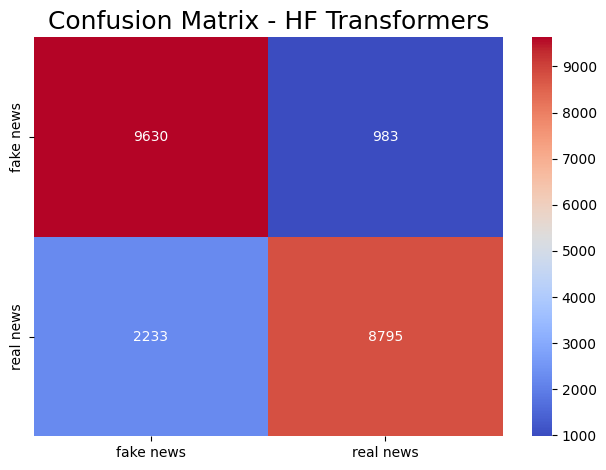

In [ ]:
ax = sns.heatmap(cm_2, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [112]:
rnn_model_2.save('trained_rnn_model_20241218_0733_ta_85.h5') # save in h5 compressed format

## Tuning RNN Model 3 - not rerun yet

In [ ]:
# Instantiate the model
rnn_model_3 = Sequential()

# Add an embedding layer
rnn_model_3.add(Embedding(input_dim=5000, output_dim=128))

# Add a simple RNN layer with 128 units
rnn_model_3.add(SimpleRNN(units=128, return_sequences=False))

# Add dropout layers to prevent overfitting
rnn_model_3.add(Dropout(rate=0.3))

# Add another dense layer and dropout layer
rnn_model_3.add(Dense(units=64, activation='relu'))
rnn_model_3.add(Dropout(rate=0.3))

# Add the final dense output layer with sigmoid activation
rnn_model_3.add(Dense(units=1, activation='sigmoid'))
# Adjust the Adam optimizer parameters


2024-12-16 12:49:09.145039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-16 12:49:09.145931: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-16 12:49:09.146741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JAMs): /proc/driver/nvidia/version does not exist
2024-12-16 12:49:09.153854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Adjust the Adam optimizer parameters
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
rnn_model_3.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


Train the Model

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and model checkpoint
history_3 = rnn_model_3.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/10
789/789 [==============================] - 158s 199ms/step - loss: 0.2165 - accuracy: 0.9163 - val_loss: 0.1348 - val_accuracy: 0.9537
Epoch 2/10
789/789 [==============================] - 159s 201ms/step - loss: 0.1260 - accuracy: 0.9552 - val_loss: 0.1353 - val_accuracy: 0.9561
Epoch 3/10
789/789 [==============================] - 155s 197ms/step - loss: 0.0994 - accuracy: 0.9654 - val_loss: 0.1573 - val_accuracy: 0.9495
Epoch 4/10
789/789 [==============================] - 155s 197ms/step - loss: 0.0705 - accuracy: 0.9756 - val_loss: 0.1722 - val_accuracy: 0.9366


Evaluate the Model

In [ ]:
# Evaluate the model on the test data
loss_3, accuracy_3 = rnn_model_3.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_3:.2f}")


677/677 [==============================] - 26s 38ms/step - loss: 0.1348 - accuracy: 0.9537
Test Accuracy: 0.95


Predict

In [ ]:
# Generate predictions
y_pred_prob_3 = rnn_model_3.predict(X_test)
# Convert probabs to 0 or 1
y_pred_3 = (y_pred_prob_3 > 0.5).astype(int)


677/677 [==============================] - 29s 42ms/step


In [ ]:
# Performance metrics
perfomance_accuracy_3 = accuracy_score(y_test, y_pred_3)
perfomance_precision_3 = precision_score(y_test, y_pred_3)
perfomance_recall_3 = recall_score(y_test, y_pred_3)
perfomance_f1_3 = f1_score(y_test, y_pred_3)

# Print performance metrics
print(f"Accuracy: {perfomance_accuracy_3:.2f}")
print(f"Precision: {perfomance_precision_3:.2f}")
print(f"Recall: {perfomance_recall_3:.2f}")
print(f"F1 Score: {perfomance_f1_3:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_3))


Accuracy: 0.95
Precision: 0.96
Recall: 0.95
F1 Score: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     10442
           1       0.96      0.95      0.95     11199

    accuracy                           0.95     21641
   macro avg       0.95      0.95      0.95     21641
weighted avg       0.95      0.95      0.95     21641



In [ ]:
# Calculate the confusion matrix
cm_3 = confusion_matrix(y_test, y_pred_3)


In [ ]:
cm_3

NameError: name 'cm_check' is not defined

In [ ]:
ax = sns.heatmap(cm_3, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [ ]:
rnn_model_3.save('trained_rnn_model_3.h5') # save in h5 compressed format

## Tuning RNN Model 4 - Test accuracy = 0.83

In [ ]:
# Instantiate the model
rnn_model_4 = Sequential()

# Add an embedding layer
rnn_model_4.add(Embedding(input_dim=5000, output_dim=128))

# Add a simple RNN layer with 128 units
rnn_model_4.add(SimpleRNN(units=32, return_sequences=False))

# Add dropout layers to prevent overfitting
rnn_model_4.add(Dropout(rate=0.1))

# Add another dense layer and dropout layer
rnn_model_4.add(Dense(units=64, activation='relu'))
rnn_model_4.add(Dropout(rate=0.1))

# Add the final dense output layer with sigmoid activation
rnn_model_4.add(Dense(units=1, activation='sigmoid'))


2024-12-17 19:54:00.738197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-17 19:54:00.740999: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-17 19:54:00.742240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JAMs): /proc/driver/nvidia/version does not exist
2024-12-17 19:54:00.786579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Compile the model
optimizer = RMSprop()
rnn_model_4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5  # Decrease the learning rate by half after 5 epochs

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with early stopping and learning rate scheduler
history_4 = rnn_model_4.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/10
789/789 [==============================] - 151s 189ms/step - loss: 0.6506 - accuracy: 0.5866 - val_loss: 0.6655 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 2/10
789/789 [==============================] - 138s 175ms/step - loss: 0.5121 - accuracy: 0.7383 - val_loss: 0.4053 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 3/10
789/789 [==============================] - 139s 176ms/step - loss: 0.4823 - accuracy: 0.7599 - val_loss: 0.6343 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 4/10
789/789 [==============================] - 145s 184ms/step - loss: 0.5184 - accuracy: 0.7123 - val_loss: 0.4169 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 5/10
789/789 [==============================] - 143s 181ms/step - loss: 0.4604 - accuracy: 0.7768 - val_loss: 0.4833 - val_accuracy: 0.7717 - lr: 0.0010


In [ ]:
# Evaluate the model on the test data
loss_4, accuracy_4 = rnn_model_4.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy_4:.2f}")


677/677 [==============================] - 23s 34ms/step - loss: 0.4053 - accuracy: 0.8302
Test Accuracy: 0.83


In [ ]:
# Generate predictions
y_pred_prob_4 = rnn_model_4.predict(X_test_padded)
# Convert probabs to 0 or 1
y_pred_4 = (y_pred_prob_4 > 0.5).astype(int)


677/677 [==============================] - 24s 35ms/step


In [ ]:
# rnn_model_4.predict(np.expand_dims(X_test[1, :], axis=0))

1/1 [==============================] - 0s 99ms/step


array([[0.00292652]], dtype=float32)

In [ ]:
# np.expand_dims(X_test[1, :], axis=0).shape

(1, 500)

In [ ]:
# Performance metrics
perfomance_accuracy_4 = accuracy_score(y_test, y_pred_4)
perfomance_precision_4 = precision_score(y_test, y_pred_4)
perfomance_recall_4 = recall_score(y_test, y_pred_4)
perfomance_f1_4 = f1_score(y_test, y_pred_4)

# Print performance metrics
print(f"Accuracy: {perfomance_accuracy_4:.2f}")
print(f"Precision: {perfomance_precision_4:.2f}")
print(f"Recall: {perfomance_recall_4:.2f}")
print(f"F1 Score: {perfomance_f1_4:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_4))


Accuracy: 0.83
Precision: 0.95
Recall: 0.71
F1 Score: 0.81
Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.96      0.85     10613
        True       0.95      0.71      0.81     11028

    accuracy                           0.83     21641
   macro avg       0.85      0.83      0.83     21641
weighted avg       0.85      0.83      0.83     21641



In [ ]:
# Calculate the confusion matrix
cm_4 = confusion_matrix(y_test, y_pred_4)


In [113]:
cm_4

NameError: name 'cm_4' is not defined

In [ ]:
ax = sns.heatmap(cm_4, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [ ]:
rnn_model_4.save('trained_rnn_model_20241217_2021.h5') # save in h5 compressed format

# LSTM Models

## LSTM model 1 - Test accuracy = 0.97

### Modelling and training

In [40]:
# Instantiate the LSTM model
lstm_model_1 = Sequential()

# Add an embedding layer
lstm_model_1.add(Embedding(input_dim=5000, output_dim=128, input_length=500))

# Add the LSTM layer
lstm_model_1.add(LSTM(units=128, return_sequences=False))

# Add a dropout layer to prevent overfitting
lstm_model_1.add(Dropout(rate=0.2))

# Add another dense layer and dropout layer
lstm_model_1.add(Dense(units=64, activation='relu'))
lstm_model_1.add(Dropout(rate=0.2))

# Add the dense output layer
lstm_model_1.add(Dense(units=1, activation='sigmoid'))


In [41]:
# Adjust the Adam optimizer parameters
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model with Adam optimizer and binary cross-entropy loss
lstm_model_1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history_5 = lstm_model_1.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
789/789 [==============================] - 598s 757ms/step - loss: 0.6510 - accuracy: 0.5849 - val_loss: 0.6547 - val_accuracy: 0.5849
Epoch 2/10
789/789 [==============================] - 596s 756ms/step - loss: 0.5556 - accuracy: 0.7183 - val_loss: 0.4950 - val_accuracy: 0.7898
Epoch 3/10
789/789 [==============================] - 624s 791ms/step - loss: 0.5486 - accuracy: 0.6929 - val_loss: 0.5620 - val_accuracy: 0.6743
Epoch 4/10
789/789 [==============================] - 639s 810ms/step - loss: 0.3346 - accuracy: 0.8739 - val_loss: 0.3192 - val_accuracy: 0.8834
Epoch 5/10
789/789 [==============================] - 643s 815ms/step - loss: 0.1497 - accuracy: 0.9510 - val_loss: 0.1184 - val_accuracy: 0.9612
Epoch 6/10
789/789 [==============================] - 643s 815ms/step - loss: 0.0811 - accuracy: 0.9755 - val_loss: 0.0850 - val_accuracy: 0.9726
Epoch 7/10
789/789 [==============================] - 642s 814ms/step - loss: 0.0536 - accuracy: 0.9849 - val_loss: 0.0801 -

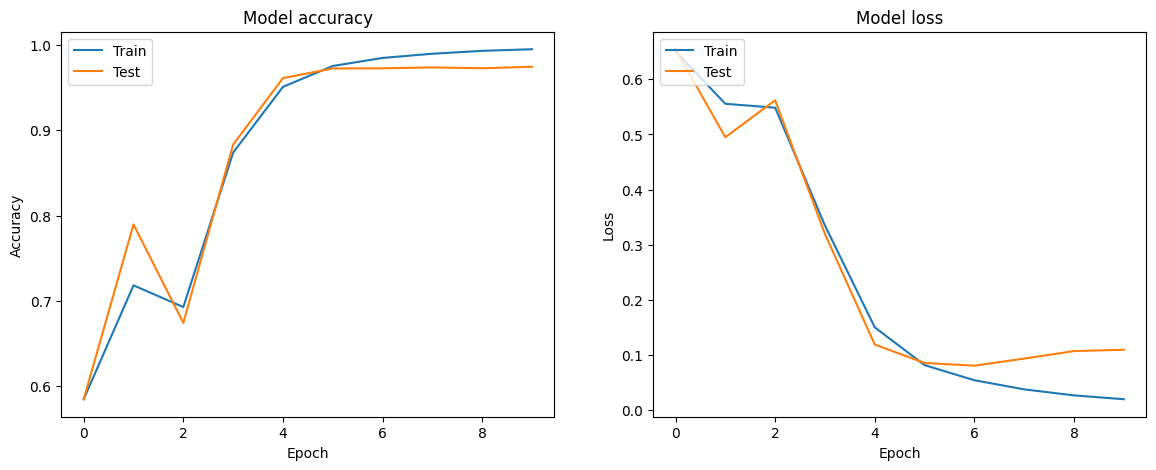

In [43]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [44]:
# Evaluate the model on the test data
loss_5, accuracy_5 = lstm_model_1.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy_5:.2f}")

677/677 [==============================] - 116s 171ms/step - loss: 0.0801 - accuracy: 0.9727
Test Accuracy: 0.97


In [45]:
# Generate predictions
y_pred_prob_5 = lstm_model_1.predict(X_test_padded)
# Convert probabs to 0 or 1
y_pred_5 = (y_pred_prob_5 > 0.5).astype(int)

677/677 [==============================] - 123s 181ms/step


In [ ]:
# Performance metrics
perfomance_accuracy_5 = accuracy_score(y_test, y_pred_5)
perfomance_precision_5 = precision_score(y_test, y_pred_5)
perfomance_recall_5 = recall_score(y_test, y_pred_5)
perfomance_f1_5 = f1_score(y_test, y_pred_5)

# Print performance metrics
print(f"Accuracy: {perfomance_accuracy_5:.2f}")
print(f"Precision: {perfomance_precision_5:.2f}")
print(f"Recall: {perfomance_recall_5:.2f}")
print(f"F1 Score: {perfomance_f1_5:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_5))


Accuracy: 0.97
Precision: 0.97
Recall: 0.98
F1 Score: 0.97
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.96      0.97     10613
        True       0.97      0.98      0.97     11028

    accuracy                           0.97     21641
   macro avg       0.97      0.97      0.97     21641
weighted avg       0.97      0.97      0.97     21641



In [48]:
# Calculate the confusion matrix
cm_5 = confusion_matrix(y_test, y_pred_5)

In [49]:
cm_5

array([[10221,   392],
       [  198, 10830]])

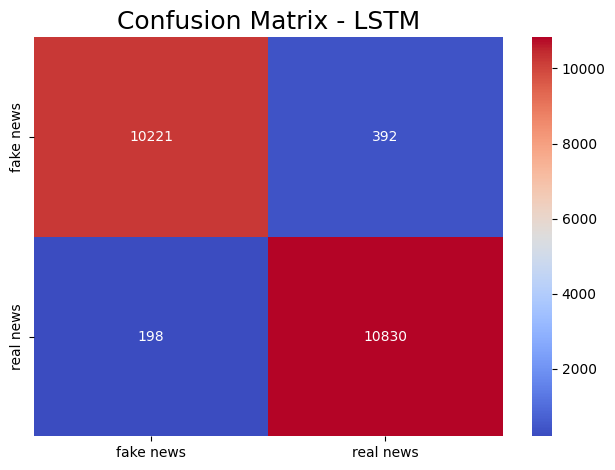

In [71]:
ax = sns.heatmap(cm_5, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - LSTM',fontsize=18)

plt.tight_layout()

In [51]:
lstm_model_1.save('trained_lstm_model_20241218_1337_ta_97.h5') # save in h5 compressed format

### Loading saved model and testing

In [13]:
trained_lstm_model_vlad = tf.keras.models.load_model('trained_lstm_model_vlad.h5')

2024-12-18 15:40:31.575777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-18 15:40:31.576563: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-18 15:40:31.577103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JAMs): /proc/driver/nvidia/version does not exist
2024-12-18 15:40:31.583622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
trained_lstm_model_vlad.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 779,905
Trainable params: 779,905
Non-trai

In [ ]:
# def text_basic_cleaning(text: str) -> str:
#     # stripping:
#     text = text.strip()

#     # tolower:
#     text = text.lower()

#     # digit: Remove digits
#     text = ''.join(char for char in text if not char.isdigit())

#     # punctuation: Remove all punctuation marks
#     text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)

#     # delete html-tags
#     text = re.sub('<[^<]+?>', '', text)

#     return text


In [ ]:
# def preprocess_text(text: str) -> str:

#     # Tokenisation
#     tokens = word_tokenize(text)

#     # Remove stop words
#     tokens = delete_stop_words(tokens)

#     # Lemmatisation
#     tokens = lemmatize_text(tokens)

#     # Combine words into a string
#     processed_text = ' '.join(tokens)

#     return processed_text


In [15]:
y_test.head(20)

Unnamed: 0
61370     True
2189      True
60609    False
51565    False
39431     True
47839     True
42729     True
37882    False
10893    False
46977     True
48546     True
9712      True
28626    False
30338    False
42408     True
13072     True
43920     True
41529     True
24096    False
55641     True
Name: label, dtype: bool

In [23]:
# Select a specific row from X_test
row_index = 18  # Change this index to select a different row
sample_text = X_test.iloc[row_index]
sample_label = y_test.iloc[row_index]

print(f"Selected text: {sample_text}")
print(f"Actual label: {sample_label}")


Selected text: 'The only other option': Bernie Sanders backers turn to Green party's Jill Stein Vanessa Tijerina was not politically active until a couple years ago. Then she started looking closely at problems in the healthcare system, feeling that mainstream politicians were not delivering solutions – and discovered Bernie Sanders.

Last September, at short notice, she drove three hours to San Antonio, Texas, from her home near the border with Mexico so she could join other Sanders supporters in a protest against a Democratic congressman who had criticised the Vermont senator. In January she marched through Manhattan for Sanders, inspired by his idealistic and unorthodox message.

And then the 74-year-old lost the Democratic presidential primary to Hillary Clinton, and backed her for the White House last month at the national convention. That was where Tijerina and Sanders diverged.

“A lot of us waited with bated breath, wondering: what’s he going to do?” she said. “Because dependin

In [24]:
# Apply the basic cleaning function
sample_text_basic_clean = basic_cleaning(sample_text)
print(sample_text_basic_clean)

# Apply the NLP cleaning function
sample_text_preprocess = nlp_cleaning(sample_text_basic_clean)
print(sample_text_preprocess)

# Tokenize sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sample_text_preprocess)
sample_text_seq = tokenizer.texts_to_sequences(sample_text_preprocess)

# Pad sequences to ensure uniform input length
sample_text_padded = pad_sequences(sample_text_seq, maxlen=500)

# Make predictions using the trained model
prediction = trained_lstm_model_vlad.predict(sample_text_padded)

# Interpret the prediction as a probability
probability_real = prediction[0][0]
probability_fake = 1 - probability_real

print(f"Probability of being real news: {probability_real:.2f}")
print(f"Probability of being fake news: {probability_fake:.2f}")

# Interpret the prediction (assuming a binary classification model)
if probability_real > 0.5:
    print("The article is likely real news.")
else:
    print("The article is likely fake news.")


the only other option bernie sanders backers turn to green partys jill stein vanessa tijerina was not politically active until a couple years ago then she started looking closely at problems in the healthcare system feeling that mainstream politicians were not delivering solutions – and discovered bernie sanders

last september at short notice she drove three hours to san antonio texas from her home near the border with mexico so she could join other sanders supporters in a protest against a democratic congressman who had criticised the vermont senator in january she marched through manhattan for sanders inspired by his idealistic and unorthodox message

and then the yearold lost the democratic presidential primary to hillary clinton and backed her for the white house last month at the national convention that was where tijerina and sanders diverged

“a lot of us waited with bated breath wondering what’s he going to do” she said “because depending on what he did that’s where the moveme

## LSTM model 2 - Test accuracy = 0.94

### Modelling and training

In [25]:
# Instantiate the LSTM model
lstm_model_2 = Sequential()

# Add an embedding layer
lstm_model_2.add(Embedding(input_dim=5000, output_dim=16, input_length=500, mask_zero=True))

# Add the LSTM layer
lstm_model_2.add(LSTM(units=16, return_sequences=False))
lstm_model_2.add(Dense(units=1, activation='sigmoid'))


2024-12-19 08:32:47.911021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-19 08:32:47.911377: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-19 08:32:47.911447: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JAMs): /proc/driver/nvidia/version does not exist
2024-12-19 08:32:47.913650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Adjust the Adam optimizer parameters
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with Adam optimizer and binary cross-entropy loss
lstm_model_2.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history_6 = lstm_model_2.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
395/395 [==============================] - 173s 429ms/step - loss: 0.3224 - accuracy: 0.8731 - val_loss: 0.1985 - val_accuracy: 0.9329
Epoch 2/10
395/395 [==============================] - 196s 496ms/step - loss: 0.1686 - accuracy: 0.9435 - val_loss: 0.1693 - val_accuracy: 0.9403
Epoch 3/10
395/395 [==============================] - 175s 444ms/step - loss: 0.1509 - accuracy: 0.9507 - val_loss: 0.1650 - val_accuracy: 0.9431
Epoch 4/10
395/395 [==============================] - 191s 484ms/step - loss: 0.1788 - accuracy: 0.9395 - val_loss: 0.2172 - val_accuracy: 0.9048
Epoch 5/10
395/395 [==============================] - 201s 508ms/step - loss: 0.1352 - accuracy: 0.9550 - val_loss: 0.1772 - val_accuracy: 0.9377
Epoch 6/10
395/395 [==============================] - 186s 472ms/step - loss: 0.1189 - accuracy: 0.9620 - val_loss: 0.1569 - val_accuracy: 0.9482
Epoch 7/10
395/395 [==============================] - 209s 530ms/step - loss: 0.1089 - accuracy: 0.9652 - val_loss: 0.1527 -

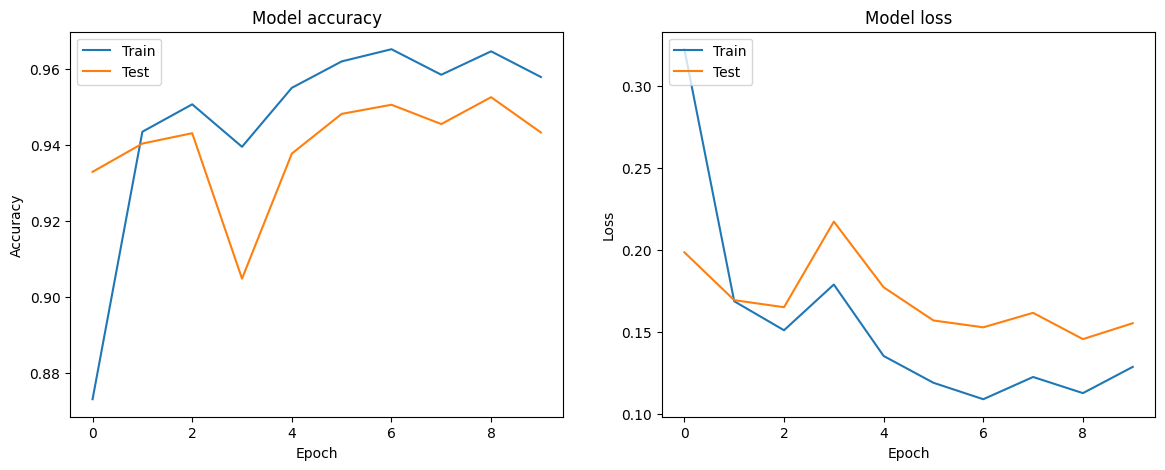

In [28]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [29]:
# Evaluate the model on the test data
loss_6, accuracy_6 = lstm_model_2.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy_6:.2f}")

677/677 [==============================] - 56s 82ms/step - loss: 0.1552 - accuracy: 0.9433
Test Accuracy: 0.94


In [30]:
# Generate predictions
y_pred_prob_6 = lstm_model_2.predict(X_test_padded)
# Convert probabs to 0 or 1
y_pred_6 = (y_pred_prob_6 > 0.5).astype(int)

677/677 [==============================] - 41s 57ms/step


In [31]:
# Performance metrics
perfomance_accuracy_6 = accuracy_score(y_test, y_pred_6)
perfomance_precision_6 = precision_score(y_test, y_pred_6)
perfomance_recall_6 = recall_score(y_test, y_pred_6)
perfomance_f1_6 = f1_score(y_test, y_pred_6)

# Print performance metrics
print(f"Accuracy: {perfomance_accuracy_6:.2f}")
print(f"Precision: {perfomance_precision_6:.2f}")
print(f"Recall: {perfomance_recall_6:.2f}")
print(f"F1 Score: {perfomance_f1_6:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_6))


Accuracy: 0.94
Precision: 0.94
Recall: 0.95
F1 Score: 0.94
Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.94      0.94     10613
        True       0.94      0.95      0.94     11028

    accuracy                           0.94     21641
   macro avg       0.94      0.94      0.94     21641
weighted avg       0.94      0.94      0.94     21641



In [32]:
# Calculate the confusion matrix
cm_6 = confusion_matrix(y_test, y_pred_6)

In [33]:
cm_6

array([[ 9950,   663],
       [  565, 10463]])

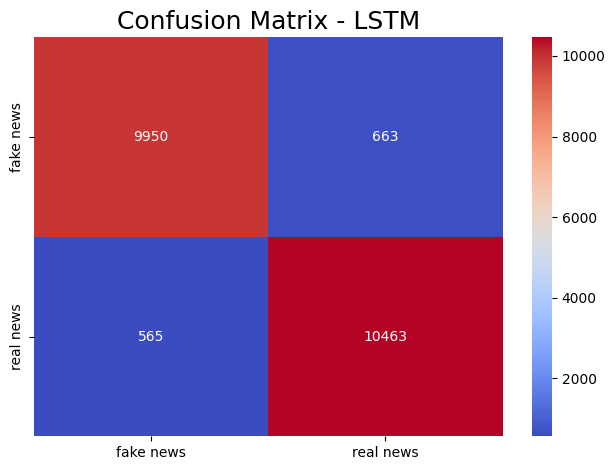

In [34]:
ax = sns.heatmap(cm_6, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - LSTM',fontsize=18)

plt.tight_layout()

In [35]:
lstm_model_2.save('trained_lstm_model_20241219_0909_ta_97.h5') # save in h5 compressed format

### Loading and predicting

In [36]:
trained_lstm_model_2 = tf.keras.models.load_model('trained_lstm_model_20241219_0909_ta_97.h5')

In [37]:
trained_lstm_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           80000     
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 82,129
Trainable params: 82,129
Non-trainable params: 0
_________________________________________________________________


In [38]:
y_test.head(20)

Unnamed: 0
61370     True
2189      True
60609    False
51565    False
39431     True
47839     True
42729     True
37882    False
10893    False
46977     True
48546     True
9712      True
28626    False
30338    False
42408     True
13072     True
43920     True
41529     True
24096    False
55641     True
Name: label, dtype: bool

In [49]:
# Select a specific row from X_test
row_index = 8  # Change this index to select a different row
sample_text = X_test.iloc[row_index]
sample_label = y_test.iloc[row_index]

print(f"Selected text: {sample_text}")
print(f"Actual label: {sample_label}")


Selected text: Trump to Republican senators: Don't leave town until pass healthcare legislation WASHINGTON (Reuters) - U.S. President Donald Trump urged Republican senators on Wednesday to work out their differences and pass healthcare legislation before leaving Washington for their August recess. A day after the latest version of legislation to replace Obamacare fell victim to squabbling among Republicans who control the Senate, Trump gathered Republican senators for a lunch and told them, “We are so close.” He said Republicans had promised Americans they would repeal and replace President Barack Obama’s signature healthcare law for seven years and that now is the time to act. “We have to stay here. We shouldn’t leave town,” Trump said. 
Actual label: False


In [ ]:
# Load the tokenizer
with open('tokenizer.pkl', 'rb') as file:
    loaded_tokenizer = pickle.load(file)

# Apply the basic cleaning function
sample_text_basic_clean = basic_cleaning(sample_text)
print(sample_text_basic_clean)

# Apply the NLP cleaning function
sample_text_preprocess = nlp_cleaning(sample_text_basic_clean)
print(sample_text_preprocess)

# Tokenize sequences
sample_text_seq = loaded_tokenizer.texts_to_sequences([sample_text_preprocess])

# Pad sequences to ensure uniform input length
max_length = 500
sample_text_padded = pad_sequences(sample_text_seq, maxlen=max_length, dtype='float32', padding='pre', value=0)

# Make predictions using the trained model
prediction = trained_lstm_model_2.predict(sample_text_padded)

# Interpret the prediction as a probability
probability_real = prediction[0][0]
probability_fake = 1 - probability_real

print(f"Probability of being real news: {probability_real:.2f}")
print(f"Probability of being fake news: {probability_fake:.2f}")

# Interpret the prediction (assuming a binary classification model)
if probability_real > 0.5:
    print("The article is likely real news.")
else:
    print("The article is likely fake news.")


trump to republican senators dont leave town until pass healthcare legislation washington reuters  us president donald trump urged republican senators on wednesday to work out their differences and pass healthcare legislation before leaving washington for their august recess a day after the latest version of legislation to replace obamacare fell victim to squabbling among republicans who control the senate trump gathered republican senators for a lunch and told them “we are so close” he said republicans had promised americans they would repeal and replace president barack obama’s signature healthcare law for seven years and that now is the time to act “we have to stay here we shouldn’t leave town” trump said
trump republican senator dont leave town pas healthcare legislation washington reuters u president donald trump urge republican senator wednesday work difference pas healthcare legislation leave washington august recess day latest version legislation replace obamacare fell victim s

# Sample texts

In [ ]:
# Filter the X_test dataset to get only the fake news entries
fake_texts = X_test[y_test == 0]

# Randomly sample 30 fake news entries (example dataset may have fewer than 30)
random_fake_texts = fake_texts.sample(n=min(30, len(fake_texts)), random_state=42)

# Write the sampled fake texts to a .txt file
with open('random_fake_texts.txt', 'w') as file:
    for text in random_fake_texts:
        file.write(f'text="{text}"\nlabel=False\n\n######################################################################################\n\n')

print("Random fake texts have been written to random_fake_texts.txt")


Random fake texts have been written to random_fake_texts.txt


In [ ]:
# Filter the X_test dataset to get only the real news entries
real_texts = X_test[y_test == 1]

# Randomly sample 30 real news entries
random_real_texts = real_texts.sample(n=min(30, len(real_texts)), random_state=42)

# Write the sampled fake texts to a .txt file
with open('random_real_texts.txt', 'w') as file:
    for text in random_real_texts:
        file.write(f'text="{text}"\nlabel=True\n\n######################################################################################\n\n')

print("Random real texts have been written to random_real_texts.txt")


Random real texts have been written to random_real_texts.txt
